# Computational Complexity Comparison: nipals PCA vs sklearn PCA

This notebook compares the accuracy, as well as runtime and memory complexity of nipals PCA implementation with different scikit-learn's PCA implementations. 

> `ipykernel` and `matplotlib` are needed as additional dependencies to run this notebook.

## 1. Import Required Libraries

In [1]:
import time
import tracemalloc
from typing import Callable, Tuple, Any
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from open_nipals.nipalsPCA import NipalsPCA

# Set random seed for reproducibility
seed = 1337
rng = np.random.default_rng(seed)

# Configure matplotlib
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [45]:
saveflag = True
readflag = False

# set up run configs
run_configs = [
    (100, 40, [2, 4, 8, 16]),
    (50, 40, [4]),
    (500, 40, [4]),
    (1000, 40, [4]),
    (10000, 40, [4]),
    (100, 20, [4]),
    (100, 100, [4]),
    (100, 1000, [4]),
]

# testing setup
nan_pct = 0.1
decay_amp_base = 0.9
noise_amp = 0.1

# Set up working directory for saving figures
work_dir = Path.cwd()


## 2. Define Helper Functions for Benchmarking

In [46]:
def measure_runtime_and_memory(
    func: Callable, args: Any
) -> Tuple[Any, float, float]:
    """
    Measure execution time and peak memory usage of a function.

    Parameters:
    -----------
    func : Callable
        Function to measure
    args : Any
        Positional arguments to pass to func

    Returns:
    --------
    result : Any
        Return value of func
    elapsed_time : float
        Execution time in seconds
    peak_memory : float
        Peak memory usage in MB
    """
    tracemalloc.start()
    start = time.time()
    result = func(*args)
    elapsed = time.time() - start
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, elapsed, peak / (1024 * 1024)  # Convert to MB

In [47]:
def nipals_pca(X: np.ndarray, n_components: int) -> NipalsPCA:
    """
    Create and fit new nipalsPCA model.

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract

    Returns:
    --------
    out_sc_model : nipalsPCA
        Fitted nipalsPCA object
    """
    return NipalsPCA(
        n_components=n_components, max_iter=1000, tol_criteria=1e-4
    ).fit(X)

In [48]:
def nipals_pca_set_components(
    X: np.ndarray, n_components: int, sc_model: NipalsPCA = None
) -> NipalsPCA:
    """
    Apply set_components by nipalsPCA.

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract
    sc_model : nipalsPCA, optional
        Predefined nipalsPCA model

    Returns:
    --------
    out_sc_model : nipalsPCA
        Fitted nipalsPCA object
    """
    if sc_model is None:
        sc_model = NipalsPCA(
            n_components=n_components, max_iter=1000, tol_criteria=1e-4
        ).fit(X)
    else:
        sc_model.set_components(n_components)

    return sc_model

In [49]:
def sklearn_pca_simple_imputation(
    X: np.ndarray, n_components: int
) -> Tuple[SimpleImputer, PCA]:
    """
    Apply simple imputation followed by sklearn PCA.

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract

    Returns:
    --------
    imputer : SimpleImputer
        Fitted SimpleImputer object
    pca : PCA
        Fitted PCA object
    """
    imputer = SimpleImputer()
    x_imp = imputer.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=seed)
    return imputer, pca.fit(x_imp)

In [50]:
def sklearn_pca_matrix_imputation(
    X: np.ndarray, n_components: int
) -> Tuple[IterativeImputer, PCA]:
    """
    Apply iterative imputation followed by sklearn PCA.

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract

    Returns:
    --------
    imputer : IterativeImputer
        Fitted IterativeImputer object
    pca : PCA
        Fitted PCA object
    """
    imputer = IterativeImputer(max_iter=1000, random_state=seed)
    x_imp = imputer.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=seed)
    return imputer, pca.fit(x_imp)

In [51]:
def fa_em_with_imputation(
    X: np.ndarray, n_components: int
) -> Tuple[SimpleImputer, FactorAnalysis]:
    """
    Apply iterative imputation followed by Factor Analysis with EM.

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract

    Returns:
    --------
    imputer : SimpleImputer
        Fitted SimpleImputer object
    fa : FactorAnalysis
        Fitted FactorAnalysis object
    """
    imputer = SimpleImputer()
    x_imp = imputer.fit_transform(X)
    fa = FactorAnalysis(
        n_components=n_components, random_state=seed, max_iter=1000
    )
    return imputer, fa.fit(x_imp)

In [52]:
def ica_with_imputation(
    X: np.ndarray, n_components: int
) -> Tuple[SimpleImputer, FastICA]:
    """
    Apply simple imputation followed by ICA.
    max_iter = 1000 does not converge

    Parameters:
    -----------
    X : np.ndarray
        Input data with potential missing values
    n_components : int
        Number of components to extract

    Returns:
    --------
    imputer : SimpleImputer
        Fitted SimpleImputer object
    ica : FastICA
        Fitted FastICA object
    """
    imputer = SimpleImputer()
    x_imp = imputer.fit_transform(X)
    ica = FastICA(n_components=n_components, random_state=seed, max_iter=1000)
    return imputer, ica.fit(x_imp)

## 3. Generate Sparse Test Dataset

In [53]:
if not readflag:
    datasets = []

    # generate normalized random dataset for each run config
    for samp, feat, _ in run_configs:
        # decaying components magnitude without loss of generality
        amp = decay_amp_base ** np.arange(feat)

        # construct random orthogonal base
        decomp = rng.standard_normal((feat, feat))
        loadings, _ = np.linalg.qr(decomp)

        # random scores, without loss of generality
        # in decaying order
        scores = rng.standard_normal((samp, feat)) * amp

        # construct data
        x_data = scores @ loadings

        # Add small noise
        x_data += rng.standard_normal((samp, feat)) * noise_amp

        # introduce some NaN values
        nan_mask = rng.uniform(0, 1, (samp, feat)) < nan_pct
        x_data[nan_mask] = np.nan

        # unit scale
        scaler = StandardScaler()
        scaled_x_data = scaler.fit_transform(x_data)

        # add to datasets list
        datasets = datasets + [(scaled_x_data, loadings)]

## 4. Measure Runtime and Memory Complexity

In [54]:
# Store results in lists
if not readflag:
    runtime_results = []

    for (n_samples, n_features, comps), (dataset, ground_truth) in zip(
        run_configs, datasets
    ):
        # initialize for set_components
        sc_model = None

        for n_components in comps:
            print(
                f"Running for Samples: {n_samples}, Features: {n_features}, Components: {n_components}"
            )

            # Measure nipals PCA runtime

            nipals_mean_residual = np.nan
            nipals_time = np.nan
            nipals_memory = np.nan
            try:
                nipals_obj, nipals_time, nipals_memory = (
                    measure_runtime_and_memory(
                        nipals_pca,
                        (dataset, n_components),
                    )
                )
                nipals_mean_residual = np.nanmean(
                    np.absolute(
                        nipals_obj.inverse_transform(
                            nipals_obj.transform(dataset)
                        )
                        - dataset
                    ).reshape(-1)
                )
            except Exception as e:
                print(
                    f"nipals PCA failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Measure nipals PCA runtime with set_components
            sc_nipals_mean_residual = np.nan
            sc_nipals_time = np.nan
            sc_nipals_memory = np.nan
            try:
                sc_nipals_obj, sc_nipals_time, sc_nipals_memory = (
                    measure_runtime_and_memory(
                        nipals_pca_set_components,
                        (
                            dataset,
                            n_components,
                            sc_model,
                        ),
                    )
                )
                sc_nipals_mean_residual = np.nanmean(
                    np.absolute(
                        sc_nipals_obj.inverse_transform(
                            sc_nipals_obj.transform(dataset)
                        )
                        - dataset
                    ).reshape(-1)
                )
            except Exception as e:
                print(
                    f"nipals PCA set_component failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Measure sklearn PCA runtime with simple imputation
            simple_sklearn_mean_residual = np.nan
            simple_sklearn_time = np.nan
            simple_sklearn_memory = np.nan
            try:
                (
                    (simple_sklearn_imp, simple_sklearn_obj),
                    simple_sklearn_time,
                    simple_sklearn_memory,
                ) = measure_runtime_and_memory(
                    sklearn_pca_simple_imputation, (dataset, n_components)
                )
                simple_sklearn_mean_residual = np.nanmean(
                    np.absolute(
                        simple_sklearn_obj.inverse_transform(
                            simple_sklearn_obj.transform(
                                simple_sklearn_imp.transform(dataset)
                            )
                        )
                        - dataset
                    ).reshape(-1)
                )
            except Exception as e:
                print(
                    f"sklearn PCA simple imputation failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Measure sklearn PCA runtime with matrix imputation
            matrix_sklearn_mean_residual = np.nan
            matrix_sklearn_time = np.nan
            matrix_sklearn_memory = np.nan
            try:
                if n_features <= 100:
                    (
                        (matrix_sklearn_imp, matrix_sklearn_obj),
                        matrix_sklearn_time,
                        matrix_sklearn_memory,
                    ) = measure_runtime_and_memory(
                        sklearn_pca_matrix_imputation, (dataset, n_components)
                    )
                    matrix_sklearn_mean_residual = np.nanmean(
                        np.absolute(
                            matrix_sklearn_obj.inverse_transform(
                                matrix_sklearn_obj.transform(
                                    matrix_sklearn_imp.transform(dataset)
                                )
                            )
                            - dataset
                        ).reshape(-1)
                    )
                else:
                    # invoke exception to push to except block
                    raise MemoryError("Skipping due to high feature count")
            except Exception as e:
                print(
                    f"sklearn PCA matrix imputation failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Measure Factor Analysis with EM
            fa_mean_residual = np.nan
            fa_time = np.nan
            fa_memory = np.nan
            try:
                (fa_imp, fa_obj), fa_time, fa_memory = (
                    measure_runtime_and_memory(
                        fa_em_with_imputation, (dataset, n_components)
                    )
                )
                fa_mean_residual = np.nanmean(
                    np.absolute(
                        (
                            fa_obj.transform(fa_imp.transform(dataset))
                            @ fa_obj.components_
                            + fa_obj.mean_
                        )
                        - dataset
                    ).reshape(-1)
                )
            except Exception as e:
                print(
                    f"FA/EM failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Measure ICA with simple imputation
            ica_mean_residual = np.nan
            ica_time = np.nan
            ica_memory = np.nan
            try:
                (ica_imp, ica_obj), ica_time, ica_memory = (
                    measure_runtime_and_memory(
                        ica_with_imputation, (dataset, n_components)
                    )
                )
                ica_mean_residual = np.nanmean(
                    np.absolute(
                        ica_obj.inverse_transform(
                            ica_obj.transform(ica_imp.transform(dataset))
                        )
                        - dataset
                    ).reshape(-1)
                )
            except Exception as e:
                print(
                    f"ICA failed for ({n_samples}, {n_features}, {n_components}): {e}"
                )

            # Save if at least one method succeeded
            result_row = {
                "Samples": n_samples,
                "Features": n_features,
                "Components": n_components,
                "nipals time (s)": nipals_time,
                "set comp nipals time (s)": sc_nipals_time,
                "simple sklearn time (s)": simple_sklearn_time,
                "matrix sklearn time (s)": simple_sklearn_time,
                "FA/EM time (s)": fa_time,
                "ICA time (s)": ica_time,
                "nipals memory (MB)": nipals_memory,
                "set comp nipals memory (MB)": sc_nipals_memory,
                "simple sklearn memory (MB)": simple_sklearn_memory,
                "matrix sklearn memory (MB)": matrix_sklearn_memory,
                "FA/EM memory (MB)": fa_memory,
                "ICA memory (MB)": ica_memory,
                "nipals mean residual": nipals_mean_residual,
                "set comp nipals mean residual": sc_nipals_mean_residual,
                "simple sklearn mean residual": simple_sklearn_mean_residual,
                "matrix sklearn mean residual": matrix_sklearn_mean_residual,
                "FA/EM mean residual": fa_mean_residual,
                "ICA mean residual": ica_mean_residual,
            }

            runtime_results.append(result_row)

    # convert to df
    runtime_df = pd.DataFrame(runtime_results)

    # print
    runtime_df
else:
    runtime_df = pd.read_csv(work_dir.joinpath("pca_benchmark_results.csv"))
    runtime_df

Running for Samples: 100, Features: 40, Components: 2
Running for Samples: 100, Features: 40, Components: 4


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 100, Features: 40, Components: 8


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 100, Features: 40, Components: 16


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 50, Features: 40, Components: 4
Running for Samples: 500, Features: 40, Components: 4
Running for Samples: 1000, Features: 40, Components: 4


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 10000, Features: 40, Components: 4
Running for Samples: 100, Features: 20, Components: 4


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 100, Features: 100, Components: 4


c:\Users\NSchluss\AppData\Local\miniconda3\envs\open_nipals_bb\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Running for Samples: 100, Features: 1000, Components: 4
sklearn PCA matrix imputation failed for (100, 1000, 4): Skipping due to high feature count


In [55]:
# save if desired
if saveflag:
    runtime_df.to_csv(
        work_dir.joinpath("pca_benchmark_results.csv"), index=False
    )

## 5. Visualize Results

In [56]:
# get minima and maxima for plotting limits
limits = {}
for param in ["time", "memory"]:
    cols = [c for c in runtime_df.columns if param in c]

    loc_min = runtime_df[cols].min().min()
    loc_max = runtime_df[cols].max().max()

    loc_min -= 10 ** np.floor(np.log10(loc_min))
    loc_max += 10 ** np.floor(np.log10(loc_max))

    limits[param] = [loc_min, loc_max]

In [57]:
# prepare sub dataframes
loc_df_comp = runtime_df[
    (runtime_df["Samples"] == 100) & (runtime_df["Features"] == 40)
].sort_values(by="Components")

loc_df_feat = runtime_df[
    (runtime_df["Samples"] == 100) & (runtime_df["Components"] == 4)
].sort_values(by="Features")

loc_df_samp = runtime_df[
    (runtime_df["Features"] == 40) & (runtime_df["Components"] == 4)
].sort_values(by="Samples")

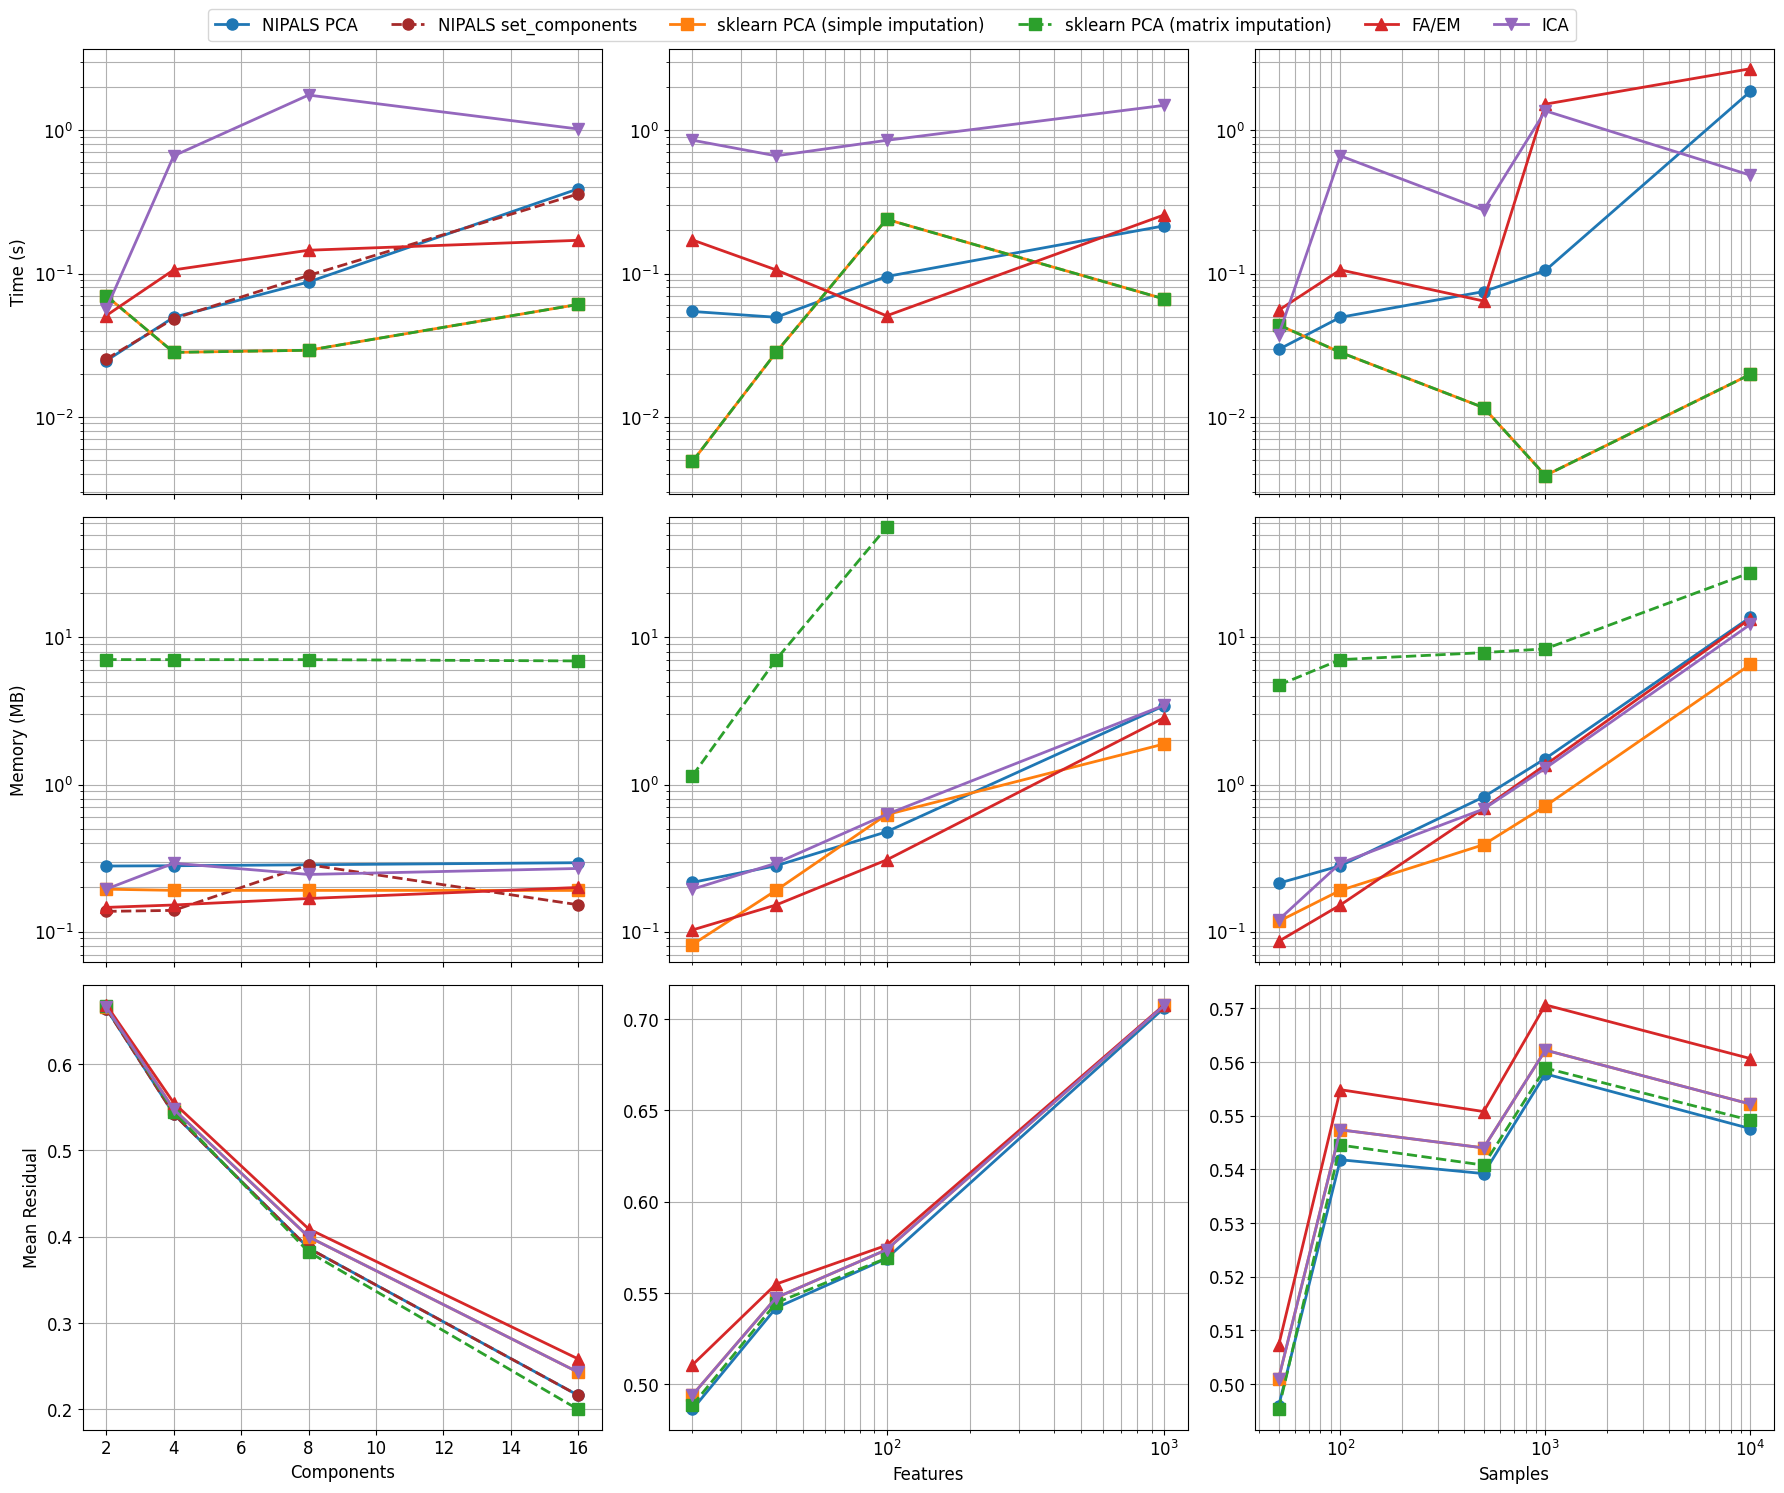

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Column 1: Components complexity
# Runtime plot
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["nipals time (s)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["set comp nipals time (s)"],
    "o--",
    linewidth=2,
    markersize=8,
    label="NIPALS set_components",
    color="brown",
)
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["simple sklearn time (s)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["matrix sklearn time (s)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["FA/EM time (s)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[0, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["ICA time (s)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[0, 0].set_ylabel("Time (s)")
axes[0, 0].set_yscale("log")
axes[0, 0].grid(True, which="both")

# Memory plot
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["nipals memory (MB)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["set comp nipals memory (MB)"],
    "o--",
    linewidth=2,
    markersize=8,
    label="NIPALS set_components",
    color="brown",
)
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["simple sklearn memory (MB)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["matrix sklearn memory (MB)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["FA/EM memory (MB)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[1, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["ICA memory (MB)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[1, 0].set_ylabel("Memory (MB)")
axes[1, 0].set_yscale("log")
axes[1, 0].grid(True, which="both")

# Mean residual plot
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["nipals mean residual"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["set comp nipals mean residual"],
    "o--",
    linewidth=2,
    markersize=8,
    label="NIPALS set_components",
    color="brown",
)
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["simple sklearn mean residual"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["matrix sklearn mean residual"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["FA/EM mean residual"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[2, 0].plot(
    loc_df_comp["Components"],
    loc_df_comp["ICA mean residual"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[2, 0].set_xlabel("Components")
axes[2, 0].set_ylabel("Mean Residual")
axes[2, 0].grid(True, which="both")

# Column 2: Features complexity
# Runtime plot
axes[0, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["nipals time (s)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[0, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["simple sklearn time (s)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[0, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["matrix sklearn time (s)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[0, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["FA/EM time (s)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[0, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["ICA time (s)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].grid(True, which="both")

# Memory plot
axes[1, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["nipals memory (MB)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[1, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["simple sklearn memory (MB)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[1, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["matrix sklearn memory (MB)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[1, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["FA/EM memory (MB)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[1, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["ICA memory (MB)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_ylim([7e-2, 1e2])
axes[1, 1].grid(True, which="both")

# Mean residual plot
axes[2, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["nipals mean residual"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[2, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["simple sklearn mean residual"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[2, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["matrix sklearn mean residual"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[2, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["FA/EM mean residual"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[2, 1].plot(
    loc_df_feat["Features"],
    loc_df_feat["ICA mean residual"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[2, 1].set_xlabel("Features")
axes[2, 1].set_xscale("log")
axes[2, 1].grid(True, which="both")

# Column 3: Samples complexity
# Runtime plot
axes[0, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["nipals time (s)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[0, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["simple sklearn time (s)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[0, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["matrix sklearn time (s)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[0, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["FA/EM time (s)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[0, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["ICA time (s)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[0, 2].set_xscale("log")
axes[0, 2].set_yscale("log")
axes[0, 2].grid(True, which="both")

# Memory plot
axes[1, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["nipals memory (MB)"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[1, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["simple sklearn memory (MB)"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[1, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["matrix sklearn memory (MB)"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[1, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["FA/EM memory (MB)"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[1, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["ICA memory (MB)"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[1, 2].set_xscale("log")
axes[1, 2].set_yscale("log")
axes[1, 2].grid(True, which="both")

# Mean residual plot
axes[2, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["nipals mean residual"],
    "o-",
    linewidth=2,
    markersize=8,
    label="NIPALS PCA",
)
axes[2, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["simple sklearn mean residual"],
    "s-",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (simple imputation)",
)
axes[2, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["matrix sklearn mean residual"],
    "s--",
    linewidth=2,
    markersize=8,
    label="sklearn PCA (matrix imputation)",
)
axes[2, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["FA/EM mean residual"],
    "^-",
    linewidth=2,
    markersize=8,
    label="FA/EM",
)
axes[2, 2].plot(
    loc_df_samp["Samples"],
    loc_df_samp["ICA mean residual"],
    "v-",
    linewidth=2,
    markersize=8,
    label="ICA",
)
axes[2, 2].set_xlabel("Samples")
axes[2, 2].set_xscale("log")
axes[2, 2].grid(True, which="both")

# Set y-axes according to global minima and maxima per row
for col in range(3):
    axes[0, col].set_ylim(limits["time"])
    axes[1, col].set_ylim(limits["memory"])

# Remove xticks for top and middle rows
for row in [0, 1]:
    for col in range(3):
        axes[row, col].set_xticklabels([])


# Add a legend to the figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.00),
    ncol=6,
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
if saveflag:
    plt.savefig(
        work_dir.joinpath("..", "plots", "combined_complexity.png"),
        bbox_inches="tight",
        dpi=600,
    )
plt.show()